# Linear Regression

<hr style="clear:both">

This notebook is part of a series of exercises for the CIVIL-226 Introduction to Machine Learning for Engineers course at EPFL. Copyright (c) 2021 [VITA](https://www.epfl.ch/labs/vita/) lab at EPFL  
Use of this source code is governed by an MIT-style license that can be found in the LICENSE file or at https://www.opensource.org/licenses/MIT

**Author(s):** [Tom Winandy](mailto:tom.winandy@epfl.ch) and [David Mizrahi](mailto:david.mizrahi@epfl.ch)
<hr style="clear:both">


In [1]:
# Function to align all tables to the left (useful for later on)

In [2]:
%%html
<style>
table {float:left}
</style>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Any, Callable

# Helper file with functions for pre-processing and visualization
import helpers

##  0. Intro 

In the first part of the exercise, you're tasked with implementing linear regression with only one variable to predict profits for a restaurant. This is known as **[simple linear regression](https://en.wikipedia.org/wiki/Simple_linear_regression)**, as opposed to **multiple linear regression** (where multiple variables are taken into account for the prediction). You'll see later on that the code implemented here will work just as well for multiple linear regression.

**Question:** How does a regression problem differ from a classification problem?

**Answer:** A regression problem searches a "tendence" like a function which the data follows and the classification tries to separate "areas" or "volumes" in different catergories.

*Background: Suppose you're the CEO of a restaurant franchise and are considering different cities for opening a new outlet. The chain already has restaurants in various cities and you have data for profits and populations from the cities. You would like to use this data to predict the profit of a restaurant based on where it opens.*

## 1. Data loading & pre-processing

Here, we'll use a dataset containing 97 restaurants, with the population of the city (in 10'000's of inhabitants) they operate in and their respective profit (in 10'000's of USD). Take a look at the file `restaurant_data.csv` and see how it's loaded by running the cell below.

In [4]:
restaurant_df = pd.read_csv('data/restaurant_data.csv')

print(f"There are {restaurant_df.shape[0]} rows and {restaurant_df.shape[1]} columns.")
# Show the first 5 rows of the data
restaurant_df.head(5)

There are 97 rows and 2 columns.


,population,profit
0,6.1101,17.5920
1,5.5277,9.1302
2,8.5186,13.6620
3,7.0032,11.8540
4,5.8598,6.8233


Run the cell below to get a plot of the data. 

<Axes: xlabel='population', ylabel='profit'>

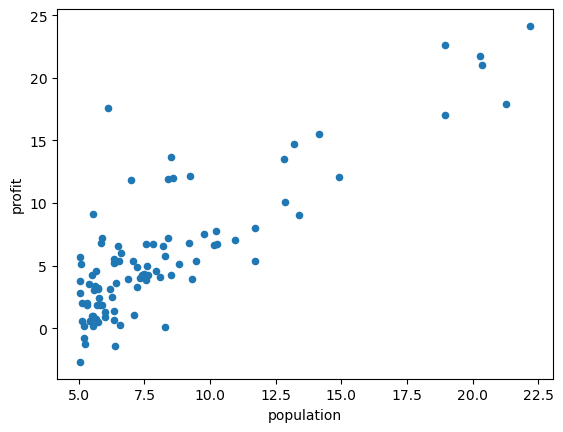

In [5]:
restaurant_df.plot(kind='scatter', x='population', y='profit')

To simplify things this time around, we'll omit the validation set. Given that there is no validation set, and that we won't implement cross-validation, we won't be able to perform any hyper-parameter search.

Here, the target label is the `profit`, and the (only) feature is the `population`.

In [6]:
# We'll use 80% of our data as training data and the remaining 20% as test data
# Here, we use a random seed to ensure that the data shuffling and splitting can be reproduced
X_train, y_train, X_test, y_test, feature_names = helpers.preprocess_data(restaurant_df, label="profit", train_size=0.8, seed=42)

### Adding the intercept

The goal of linear regression is to fit a line of slope $w_1$ and of intercept $b$ such that for any data $x^{(i)}$, the prediction $\hat{y}^{(i)}$ is:
$$\hat{y}^{(i)} = w_{1}x^{(i)} +  b$$

Note that this can also be written as:
$$\hat{y}^{(i)} = \begin{bmatrix} b & w_1 \end{bmatrix} \cdot \begin{bmatrix} 1 \\ x^{(i)} \end{bmatrix}$$

Therefore, in order to take into account the offset term ($b$) directly in our matrix, we add an additional first column to `X` and set it to all ones. Then, we treat the intercept as another feature (`b` will be treated as `w_0`), which will make our matrix computation easier.

__Note__: The same principle applies if the data has multiple features:
$$\hat{y}^{(i)} = w_{n}x^{(i)}_{n} + \ ... \ + w_{2}x^{(i)}_{2} + w_{1}x^{(i)}_{1} +  b$$
is equivalent to
$$\hat{y}^{(i)} = \begin{bmatrix} b & w_1 & w_2 & ... & w_D \end{bmatrix} \cdot \begin{bmatrix} 1 \\ x^{(i)}_{1} \\ x^{(i)}_{2} \\ ... \\ x^{(i)}_{D} \end{bmatrix}$$

Let's add a column of ones (known as the offset term / constant term) to the feature matrix `X`.

<div class="alert alert-info">
As a rule, for linear regression, the constant is always included in the feature matrix $\mathbf{X}$, and the intercept / bias term will be part to the weight vector $\mathbf{w}$. 

However, this **will not be the case** in future exercises, where the bias term will be separate.
    
</div>

In [7]:
def add_constant(X: np.ndarray) -> np.ndarray:
    """ Adds an constant term to the dataset (as the first column)

    Args:
        X (np.ndarray): Dataset of shape (N, D-1)

    Returns: 
        Dataset with offset term added, of shape (N, D)

    """
    X_with_offset = np.insert(X, 0, 1, axis=1)

    return X_with_offset

X_train = add_constant(X_train)
X_test = add_constant(X_test)

**Question:** In simple linear regression, what happens if no intercept is added?

**Answer:** The function must go through (0,0) which can make the model worse. Maybe we have a big interept but a small slope but if we don't specify the intersept, we wouldn't be able to find a good model.

### Data preview

In [8]:
print(f"Features: {feature_names}")

Features: ['population']


In [9]:
# Visualisation of X_train and y_train (separation of the features and the labels)
print('Training set features:')
print(f'X_train: \n {X_train[:10]}')

print('\nTraining set labels:')
print(f'y_train: \n {y_train[:10]}')

Training set features:
X_train: 
 [[ 1.      8.2951]
 [ 1.      9.3102]
 [ 1.     20.341 ]
 [ 1.      6.0062]
 [ 1.      7.0032]
 [ 1.      8.5781]
 [ 1.      8.2111]
 [ 1.      8.0959]
 [ 1.      5.1301]
 [ 1.      5.0269]]

Training set labels:
y_train: 
 [ 5.7442   3.9624  20.992    1.2784  11.854   12.       6.5426   4.1164
  0.56077 -2.6807 ]


In [10]:
# Show shapes
print('Training set shape:')
print(f'X: {X_train.shape}, y: {y_train.shape}')

print('\nTest set shape:')
print(f'X: {X_test.shape}, y: {y_test.shape}')

Training set shape:
X: (77, 2), y: (77,)

Test set shape:
X: (20, 2), y: (20,)


### Notation

Now that we have added the constant term, here's how our data looks like:

- features: $\boldsymbol{X} \in \mathbb{R}^{N \times D}$, $\forall \ \boldsymbol{x}^{(i)} \in \boldsymbol{X}: \boldsymbol{x}^{(i)} \in \mathbb{R}^{D}$ and $
x^{(i)}_0 = 1$
- labels: $\boldsymbol{y} \in \mathbb{R}^{N}$, $\forall \ y^{(i)} \in \boldsymbol{y}: y^{(i)} \in \mathbb{R}$ 
  
 where $N$ is the number of examples in our dataset, and $D$ is the number of features per example  
 

For the weights, we have:
 
 
 - weights: $\mathbf{w} \in \mathbb{R}^{D}$, where $w_0$ (or $b$) is known as the intercept.

 **Note:**
 $\boldsymbol{X}$ is called the design matrix, where $\boldsymbol{X}_{i, :}$ denotes $\boldsymbol{x}^{(i)}$.  
 Note that a single example $\boldsymbol{x}^{(i)}$ is a column vector of shape $(D \times 1)$, while the design matrix $\boldsymbol{X}$ is of shape $(N \times D)$, where each row represents an example and each column represents a feature.

## 2. Loss function

One of the first step when working on a machine learning problem is to pick a loss / cost function. Here, we will use the Mean Squared Error (MSE), defined as: 

$$
\begin{align}
J(\mathbf{w}) = \frac{1}{N} \sum_{i=1}^{N} (\hat{y}^{(i)} - y^{(i)})^{2} \\
= \frac{1}{N} \sum_{i=1}^{N} (\mathbf{w}^T{\boldsymbol{x}}^{(i)} - y^{(i)})^{2} \\
= \frac{1}{N} (\mathbf{X} \mathbf{w}-\mathbf{y})^{T} (\mathbf{X} \mathbf{w}-\mathbf{y})
\end{align}$$

where $N$ is the number of examples, $\hat{y}^{(i)}$ is the prediction for the $i^{th}$ example, and ${y}^{(i)}$ is the ground-truth for the $i^{th}$ example.

Implement the function `mse_loss()`

**Note about loss / cost:** The function we want to minimize or maximize is called the cost function, loss function, or error function. In this exercise, we use these terms interchangeably, though some machine learning publications assign special meaning to some of these terms.

**Hint**: Use the matrix form shown above and make use of NumPy operations.

In [11]:
def mse_loss(X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
    """Computes the Mean Square Error (MSE)
    
    Args:
        X (np.ndarray): Dataset of shape (N, D)
        y (np.ndarray): Labels of shape (N, )
        w (np.ndarray): Weights of shape (D, )

    Returns:
        float: the MSE loss
    """
    ### START CODE HERE ### (≈ 3 lines of code)

    loss = np.dot((np.dot(X, w)-y).T, (np.dot(X, w)-y))/y.shape[0]
    ### END CODE HERE ###
    return loss

Let's initialize the weights to 0 and look at the current loss.

In [12]:
zero_weights = np.zeros(X_train.shape[1])

In [13]:
train_loss = mse_loss(X_train, y_train, zero_weights)
test_loss = mse_loss(X_test, y_test, zero_weights)
print(f"Train loss: {train_loss:.5f}")
print(f"Test loss: {test_loss:.5f}")

Train loss: 62.15811
Test loss: 71.79680


**Expected output:** 

|   |                                                  |
|---|--------------------------------------------------|
| **Train loss** | 62.15811 |
| **Test loss** | 71.79680 |

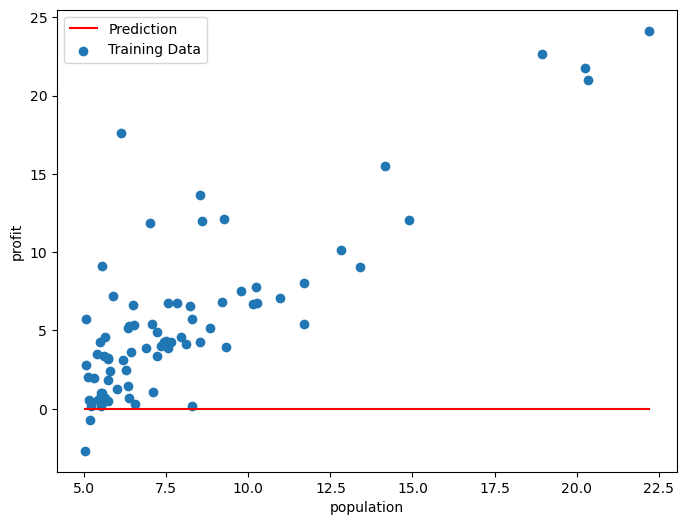

In [14]:
helpers.plot_linear_regression_2d(X=X_train, y=y_train, w=zero_weights, feature_name="population", label_name="profit")

Not great, right? We'll see in the next sections how to fit our model in order to get a much better predictor.

## 3. Gradient Descent

Now we need to define a function to perform gradient descent on the weights $\mathbf{w}$ using the update rules. First, write a function that computes the gradient of the loss function (`mse_gradient()`) and then use it in the `gradient_descent()` function to update the weights at every iteration.

As seen in the previous section, our loss is:
$$
J(\mathbf{w}) = \frac{1}{N} (\mathbf{X} \mathbf{w}-\mathbf{y})^{T} (\mathbf{X} \mathbf{w}-\mathbf{y})
$$

Therefore, the derivative w.r.t to ${\mathbf{w}}$ is:

$$ \nabla_{\mathbf{w}} J(\mathbf{w}) = \frac{2}{N} \mathbf{X}^{T} (\mathbf{X} \mathbf{w} - \mathbf{y}) 
$$

**Note:** You can use http://www.matrixcalculus.org/ to compute the gradient.


The gradient descent formula is:
$$\mathbf{w} := \mathbf{w} - \alpha \nabla_{\mathbf{w}} J(\mathbf{w})$$

where $\nabla_{\mathbf{w}} J(\mathbf{w})$ is the gradient of the loss function at the current iteration, $\mathbf{w}$ is the weights vector, and $\alpha$ is the learning rate.

**Hint**: Use the matrix form of the gradient and make use of NumPy operations.

In [30]:
def mse_gradient(X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
    """Compute the gradient of the MSE
    
    Args:
        X (np.ndarray): Dataset of shape (N, D)
        y (np.ndarray): Labels of shape (N, )
        w (np.ndarray): Weights of shape (D, )

    Returns:
        Gradient of shape (D, )
    """
    ### START CODE HERE ### (≈ 2 lines of code)
    
    grad = (2/X.shape[0])*np.dot(X.T, (np.dot(X ,w) - y))
    ### END CODE HERE ###
    return grad


In [41]:
def gradient_descent(X: np.ndarray, y: np.ndarray, w: np.ndarray, alpha: float, max_iters: int) -> (np.ndarray, np.ndarray):
    """Gradient descent for linear regression.
    
    Args:
        X (np.ndarray): Dataset of shape (N, D)
        y (np.ndarray): Labels of shape (N, )
        w (np.ndarray): Weights of shape (D, )
        alpha (float): Learning rate
        max_iters (int): Maximum number of gradient descent iteration

    Returns:
        w (np.ndarray): Optimum weights of shape (D, )
        losses (np.ndarray): Loss at every iteration of gradient descent. Shape is (max_iters, )
    """
    # Define an array to store the evolution of the loss
    losses = np.zeros(max_iters)
    
    for n_iter in range(max_iters):
        ### START CODE HERE ### (≈ 2 lines of code)
        # Update w using the gradient descent formula
        
        w = w-alpha*mse_gradient(X,y,w)
        # Compute the loss with the updated w
        loss = mse_loss(X, y, w)
        ### END CODE HERE ###
        
        # Track losses
        losses[n_iter] = loss
        
        # Print loss at some iterations
        if n_iter % (max_iters / 20) == 0:
            if w.shape[0] == 2: 
                print(f"Iteration {n_iter}: loss={loss:.5f}, w0={w[0]:.3f}, w1={w[1]:.3f}")
            else:
                print(f"Iteration {n_iter}: loss={loss:.5f}")

    return w, losses

Let's initialize some additional variables - the learning rate alpha, and the number of iterations to perform.

In [42]:
alpha = 0.01
iters = 2000
w = np.zeros((X_train.shape[1], ))

Now let's run the gradient descent algorithm to fit our parameters theta to the training set.

In [43]:
w, loss = gradient_descent(X_train, y_train, w, alpha, iters)

Iteration 0: loss=29.76341, w0=0.114, w1=1.251
Iteration 100: loss=10.95049, w0=-1.165, w1=0.914
Iteration 200: loss=10.16271, w0=-2.044, w1=1.005
Iteration 300: loss=9.76061, w0=-2.673, w1=1.070
Iteration 400: loss=9.55535, w0=-3.121, w1=1.116
Iteration 500: loss=9.45059, w0=-3.442, w1=1.149
Iteration 600: loss=9.39711, w0=-3.671, w1=1.172
Iteration 700: loss=9.36981, w0=-3.835, w1=1.189
Iteration 800: loss=9.35588, w0=-3.952, w1=1.201
Iteration 900: loss=9.34877, w0=-4.036, w1=1.210
Iteration 1000: loss=9.34514, w0=-4.095, w1=1.216
Iteration 1100: loss=9.34328, w0=-4.138, w1=1.221
Iteration 1200: loss=9.34234, w0=-4.168, w1=1.224
Iteration 1300: loss=9.34186, w0=-4.190, w1=1.226
Iteration 1400: loss=9.34161, w0=-4.206, w1=1.227
Iteration 1500: loss=9.34148, w0=-4.217, w1=1.229
Iteration 1600: loss=9.34142, w0=-4.225, w1=1.229
Iteration 1700: loss=9.34139, w0=-4.230, w1=1.230
Iteration 1800: loss=9.34137, w0=-4.235, w1=1.230
Iteration 1900: loss=9.34136, w0=-4.237, w1=1.231


Note that `gradient_descent` prints the loss and the values of the weights matrix, `w`. The reason is that `w` is at the core of our algorithm. Make sure to understand that the whole point of the learning algorithm is to update this `w` so that the linear regression model (described by `w`) fits the data as well as possible. As `X` and `y` are fixed, the only parameter that can be changed is `w`. This why we use the gradient of the loss w.r.t `w` in gradient descent. It enables us to get closer to the best value of `w` at every iteration.

Now, play with the learning rate, `alpha`, and the number of iterations, `iters`, to see how the convergence changes. Document your findings.

__Hint__: 
- Try `alpha = 0.05`. What's happening? Try to guess why.
- Try `alpha = 0.001`. Why is the final loss bigger than when `alpha = 0.01`?
- Try `alpha = 0.001` with `iters = 20 000`. Is the problem of the loss solved?

In [46]:
alpha = 0.01 # Try changing this
iters = 2000 # Try changing this
w = np.zeros((X_train.shape[1], ))
w, loss = gradient_descent(X_train, y_train, w, alpha, iters)

Iteration 0: loss=29.76341, w0=0.114, w1=1.251
Iteration 100: loss=10.95049, w0=-1.165, w1=0.914
Iteration 200: loss=10.16271, w0=-2.044, w1=1.005
Iteration 300: loss=9.76061, w0=-2.673, w1=1.070
Iteration 400: loss=9.55535, w0=-3.121, w1=1.116
Iteration 500: loss=9.45059, w0=-3.442, w1=1.149
Iteration 600: loss=9.39711, w0=-3.671, w1=1.172
Iteration 700: loss=9.36981, w0=-3.835, w1=1.189
Iteration 800: loss=9.35588, w0=-3.952, w1=1.201
Iteration 900: loss=9.34877, w0=-4.036, w1=1.210
Iteration 1000: loss=9.34514, w0=-4.095, w1=1.216
Iteration 1100: loss=9.34328, w0=-4.138, w1=1.221
Iteration 1200: loss=9.34234, w0=-4.168, w1=1.224
Iteration 1300: loss=9.34186, w0=-4.190, w1=1.226
Iteration 1400: loss=9.34161, w0=-4.206, w1=1.227
Iteration 1500: loss=9.34148, w0=-4.217, w1=1.229
Iteration 1600: loss=9.34142, w0=-4.225, w1=1.229
Iteration 1700: loss=9.34139, w0=-4.230, w1=1.230
Iteration 1800: loss=9.34137, w0=-4.235, w1=1.230
Iteration 1900: loss=9.34136, w0=-4.237, w1=1.231


Finally we can compute the loss (error) of the trained model using our fitted parameters.

In [47]:
train_loss = mse_loss(X_train, y_train, w)
test_loss = mse_loss(X_test, y_test, w)
print(f"Train loss: {train_loss:.5f}")
print(f"Test loss: {test_loss:.5f}")

Train loss: 9.34136
Test loss: 7.57149


**Expected output:** with `alpha = 0.01` and `iters = 2000`.

|   |                                                  |
|---|--------------------------------------------------|
| **Train loss** |9.34136 |
| **Test loss** | 7.57149 |

Let's also look at how the regression line looks like.

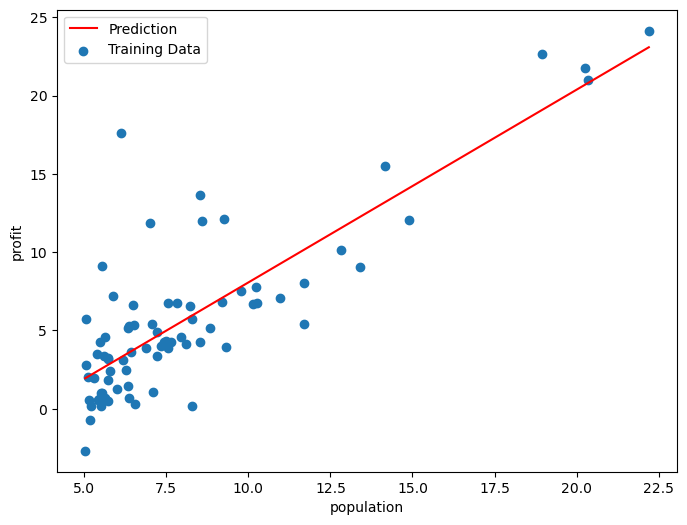

In [48]:
helpers.plot_linear_regression_2d(X=X_train, y=y_train, w=w, feature_name="population", label_name="profit")

Looks pretty good! The red line is our trained model, it represents the estimated profit of our new restaurant for every population size possible. Remember that the model is 100% described by our parameters $\mathbf{w}$ (in this case $\mathbf{w} = [b, w_1]$). If we had chosen a $\mathbf{w}$ that doesn't fit the model well, we would have gotten a red line that doesn't fit the data.

Since the gradient descent function also outputs a vector with the loss at each training iteration, we can plot that as well. The goal of gradient descent is to get a model that fits the data well, so we hope that the loss decreases throughout the iterations of gradient descent. Minimizing the MSE in linear regression is a convex optimization problem, so if everything goes well, it should reach a global minima.

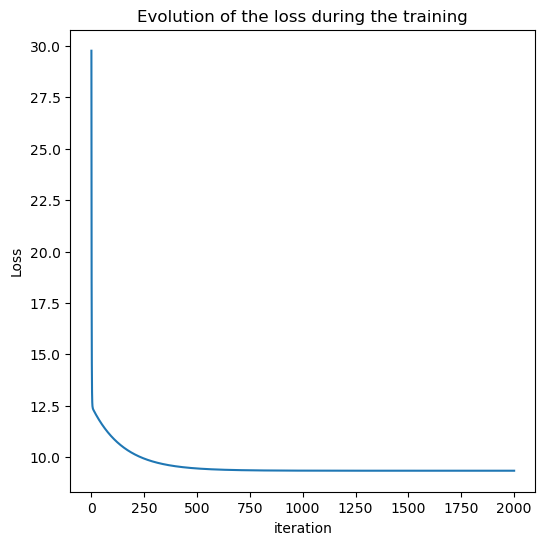

In [49]:
helpers.plot_loss(loss)

If the plot had shown a non-decreasing function, it would have raised questions about the validity of our implementation of gradient descent. In any case, it's always good practice to plot this graph to see if our algorithm works as expected. 

## 4. Least squares method

It turns out that linear regression with MSE is one of these rare cases where we can compute the optimum of the loss function analytically. Let's see how:


Let's start from the loss function: 
$$
\begin{align}
J(\mathbf{w})  = \frac{1}{N} \sum_{i=1}^{N} (\hat{y}^{(i)} -y^{(i)})^{2} \\
 = \frac{1}{N} \sum_{i=1}^{N} (\mathbf{w}^T \boldsymbol{x}^{(i)} -y^{(i)})^{2} \\
= \frac{1}{N} (\mathbf{X}\mathbf{w}-\mathbf{y})^{T}(\mathbf{X}\mathbf{w}-\mathbf{y})
\end{align}
$$

This function is convex in $\mathbf{w}$, so let's try to find its minimum.

Take the derivative with respect to $\mathbf{w}$: (Use http://www.matrixcalculus.org/ if necessary)
$$
\frac{\partial J(\mathbf{w})}{\partial \mathbf{w}}=\frac{2}{N} \mathbf{X}^{\top}(\mathbf{X} \mathbf{w} - \mathbf{y})
$$
Set to 0 and solve:
$$
\begin{align}
\frac{2}{N} \mathbf{X}^{\top}(\mathbf{X} \mathbf{w} - \mathbf{y}) = 0 \\
\Leftrightarrow \mathbf{X}^{T} \mathbf{X} \mathbf{w} = \mathbf{X}^{T} \mathbf{y}
\end{align}
$$


Therefore, the linear regression model has an analytical solution in the form of the normal equations:
$$\hat{\mathbf{w}} = (\mathbf{X}^{T}\mathbf{X)}^{-1} \ \mathbf{X}^{T} \ \mathbf{y}$$
This is known as the **least squares** method. The advantage of this method is that you can directly get the optimal weights $\mathbf{w}$ from this short matrix expression.

Please use this solution to complete the function `least_squares` and to obtain the weight parameters $\mathbf{w}$. 

**Note:** Use `np.linalg.solve` to solve a linear matrix equation, as it is more stable and more accurate than computing the inverse. You can find the documentation for this method [here](https://numpy.org/doc/stable/reference/generated/numpy.linalg.solve.html).

In [ ]:
def least_squares(X: np.ndarray, y: np.ndarray) -> np.ndarray:
    """Solves linear regression using least squares

    Args:
        X: Data of shape (N, D)
        y: Labels of shape (N, )

    Returns:
        Weight parameters of shape (D, )
    """

    ### START CODE HERE ### (≈ 1 line of code)
    w = ...
    ### END CODE HERE ###
    return w


In [ ]:
ls_w = least_squares(X_train, y_train)
print(ls_w)

In [ ]:
train_loss = mse_loss(X_train, y_train, ls_w)
test_loss = mse_loss(X_test, y_test, ls_w)
print(f"Train loss: {train_loss:.5f}")
print(f"Test loss: {test_loss:.5f}")

**Expected output:** 

|   |                                                  |
|---|--------------------------------------------------|
| **Train loss** | 9.34135 |
| **Test loss** | 7.57472 |

In [ ]:
helpers.plot_linear_regression_2d(X=X_train, y=y_train, w=ls_w, feature_name="population", label_name="profit")

**Question:** Compare the loss and plot obtained with least-squares to the loss and plot obtained with gradient descent. What can you say about these two methods, is the end result similar?

**Answer:** YOUR ANSWER HERE

## 5. Prediction
Based on the weights ($\mathbf{w}$), we just computed and the linear model, let's define a function `predict`, which we'll use to give a prediction of the expected restaurant profit ($\hat{y}$) based on the population ($x$)

In [ ]:
def predict(X, w):
    """Predicts value using linear regression weights

        Args:
            X: Dataset (without the offset) of shape (M, D)
            w: Weights (with bias term) of shape (D,)

        Returns:
            Predictions of shape (M, )
    """
    ### START CODE HERE (≈ 1 line of code)
    y_hat = ...
    ### END CODE HERE
    return y_hat

In [ ]:
# What's the predicted profit in a city of 10'000 inhabitants.
expected_profit = predict([1, 10], w)
print(f"A new restaurant in a city of 10'000 inhabitants has an expected profit of {expected_profit*1000:.2f} $.")

## 6. Multiple Linear Regression


Now, we're tasked with implementing linear regression with multiple features to predict the price of an house. We'll  see that the code implemented in the previous parts works just as well for multiple features.

*Background: Suppose you want to buy a new house and you want to figure out if its price is too low or too high based on the current house market. You know the number of rooms and the size of the house you want to buy, and you are going to predict the market price of the house based on these two features.*

### 6.1. House Dataset

Here, we'll use a dataset containing information on houses in Portland, Oregon. This dataset consists of 47 houses with their respective size (in thousands of sqft), number of bedrooms and their respective price (in USD). Take a look at the file `house_data.csv` and see how it's loaded by running the cell below.

In [ ]:
house_df = pd.read_csv('data/house_data.csv')

print(f"There are {house_df.shape[0]} rows and {house_df.shape[1]} columns.")
# Show the first 5 rows of the data
house_df.head(5)

We want to predict the price of a house using its size and number of bedrooms. 

In [ ]:
# We'll use 80% of our data as training data and the remaining 20% as test data
# Here, we use a random seed to ensure that the data shuffling and splitting can be reproduced
X_train_mult, y_train_mult, X_test_mult, y_test_mult, feature_names_mult = helpers.preprocess_data(house_df, label="price", train_size=0.8, seed=42)

As in the simple linear regression case, we'll first add a constant term to our training data for the intercept.

In [ ]:
X_train_mult = add_constant(X_train_mult)
X_test_mult = add_constant(X_test_mult)

In [ ]:
print(f"Features: {feature_names_mult}")

This time, there are several features. To be exact, we have 2 features and we can plot according to one feature at a time, to see how each feature correlates to the target variable `y`.

Run the following cell with `feature_num = 1` and then with `feature_num = 2` (`0` is the constant term).

In [ ]:
feature_num = 1
plt.scatter(X_train_mult[:,feature_num], y_train_mult)

plt.ylabel("price")
if feature_num == 0:
    plt.xlabel("constant")
    plt.title("constant vs price")
else:
    plt.xlabel(f"{feature_names_mult[feature_num - 1]}")
    plt.title(f"{feature_names_mult[feature_num - 1]} vs price")

It is also possible to plot the target variable according to both features. 

Using `plot_data_3d` from `helpers.py`, we can generate 3D plot that shows the training and test set according to both features. 
- You can toggle each dataset on or off by clicking on the legend (upper left). 
- You can also interact with the plot, zoom in and out, and see it through different angles. Try to carefully choose the view angle in order to get the equivalent of the 2 plots above (cancel one dimension).

In [ ]:
helpers.plot_data_3d(X_train=X_train_mult, y_train=y_train_mult, X_test=X_test_mult, y_test=y_test_mult, feature_names=feature_names_mult, label_name="price")

### 6.2 Normalization

Should we normalize / standardize features in multiple regression?

This depends on the regression method used:
- When using gradient descent, normalizing features can result in much faster convergence, and we'll see later on in this class a technique which takes advantage of this. However, as the scales of our features are similar here, normalization is unlikely to cause much of a difference. For more information, check out [this short post](https://stats.stackexchange.com/a/437848).

- Least square is **invariant** to normalization, so there is no need to normalize the data in this case.

Here, we'll omit the normalization step for the sake of simplicity.


### 6.3 Training

#### 6.3.1. Gradient Descent

If you have implemented the function `gradient_descent` correctly in section 1, you should be able to use it for multiple features.

Try to call `gradient_descent(X_train_mult, y_train_mult, np.zeros((X_train_mult.shape[1], )), 0.02, 5000)`. 
If it doesn't work, go back to your `gradient_descent` function in section 1, write in matrix form, rerun the function cell and try to call it again with the above parameters. 

In [ ]:
w_mult, loss = gradient_descent(X_train_mult, y_train_mult, np.zeros((X_train_mult.shape[1], )), 0.02, 5000)

Then, as usual, we can compute the loss of our newly trained model.

In [ ]:
train_loss = mse_loss(X_train_mult, y_train_mult, w_mult)
test_loss = mse_loss(X_test_mult, y_test_mult, w_mult)
print(f"Train loss: {train_loss:.1f}")
print(f"Test loss: {test_loss:.1f}")

**Expected output:** 

|   |                                                  |
|---|--------------------------------------------------|
| **Train loss** | 4320753675.3 |
| **Test loss** | 3673378116.2 |

#### 6.3.2. Least squares

If `least_squares` is implemented correctly, it should also be able to work without any modification for multiple features.

In [ ]:
ls_w_mult = least_squares(X_train_mult, y_train_mult)
print(ls_w_mult)

In [ ]:
train_loss = mse_loss(X_train_mult, y_train_mult, ls_w_mult)
test_loss = mse_loss(X_test_mult, y_test_mult, ls_w_mult)
print(f"Train loss: {train_loss:.1f}")
print(f"Test loss: {test_loss:.1f}")

**Expected output:** 

|   |                                                  |
|---|--------------------------------------------------|
| **Train loss** | 4320753667.6 |
| **Test loss** | 3673281817.0 |

This output is a realistic one. Taking the square root of the test loss we get an approximation of the average difference between our model prediction and the reality (the Root Mean Square Error, or RMSE).

In [ ]:
average_difference = np.sqrt(test_loss)
print("The average difference between the predicted price and the actual price of a house (on the test set) is",average_difference,"$.")

When using MSE, this is a good practice to make sense of the result loss in a tangible way in order to evaluate if the model performs well or not. A big loss doesn't necessarily translates to a poor model. For example, here, our model has a ~18% relative error (because the average house price is 340,000$). If we had obtain the same loss for a model predicting a variable of average value 65 000, the same loss would have translated to a ~92% relative error.

### 6.4. Plotting the regression surface

Now that our model is trained, we can plot the regression surface using `plot_surface_3d` from `helpers`. 

In [ ]:
helpers.plot_surface_3d(w=w_mult,
                        X_train=X_train_mult, 
                        y_train=y_train_mult, 
                        X_test=X_test_mult, 
                        y_test=y_test_mult,
                        feature_names=feature_names_mult, 
                        label_name="price")

**Question:**
What are your thoughts on this regression fit?

**Answer:**
YOUR ANSWER HERE

Congratulations on finishing this exercise! In the next exercise, we'll take a look at classification with logistic regression.